In [1]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.4     crayon_1.5.2    digest_0.6.31   utf8_1.2.2     
 [5] IRdisplay_1.1   repr_1.1.5      lifecycle_1.0.3 jsonlite_1.8.4 
 [9] evaluate_0.20   pillar_1.8.1    rlang_1.0.6     cli_3.6.0      
[13] uuid_1.1-0      vctrs_0.5.2     IRkernel_1.3.2  tools_4.2.2    
[17] glue_1.6.2      fastmap_1.1.0   compiler_4.2.2  base64enc_0.1-3
[21] pbdZMQ_0.3-9    htmltools_0.5.4

In [2]:
library(ggplot2)
library(statmod)

# Numerical integration

### Goal

To evaluate $\int_a^b f(x) dx$, $f:[a, b] \to \mathbb{R}$.

* Only a few functions can be integrated analytically
* For the rest, we resort to numerical approximation

Why do we need integrals?

1. Expectation
    - $X$ has some density on $[0, 1]$; $Y = \sin(X)$
    - $\mathbf{E}[Y] = \int_0^1 \sin(x)f_X(x)dx$
    
2. Bayesian inference
    - Parameter $\theta$ has a prior density $f_{\Theta}(\theta)$ on $\mathbb{R}$
    - Likelihood of data $x$ is $f_{X|\Theta}(x|\theta)$
    - Want to evaluate the posterior density
$$
    f_{\Theta|X}(\theta|x) = \frac{f_{X|\Theta}(x|\theta)f_{\Theta}(\theta)}{\int_{-\infty}^{\infty} f_{X|\Theta}(x|\theta')f_{\Theta}(\theta')d\theta'}
$$
    - The integral in the denominator may not be analytically solved.

3. MLE of structured data
    - Data: $y_{ij}$ = # recalled words by $i$th patient of Alzheimer's disease in $j$th month, $i=1,\dotsc, n$, $j=1, \dotsc, T$
    - Model:
\begin{align*}
    Y_{ij} | \lambda_{ij} &\stackrel{indep}{\sim} \text{Poi}(\lambda_{ij}), \quad j=1,\dotsc, T\\
    \lambda_{ij} &= \exp(\gamma_i + \beta_0 + j\beta_1) \\
    \gamma_i &\stackrel{i.i.d.}{\sim} N(0, \sigma^2), \quad i=1, \dots, n
\end{align*}
    - Called a generaized linear mixed model (here, Poisson GLM with a *random intercept*)
    - Likelihood:
\begin{align*}
    L(\beta_0, \beta_1, \sigma^2) &= \prod_{i=1}^n p(y_{i1}, \dotsc, y_{iT}) \\
        &= \prod_{i=1}^n \int_{-\infty}^{\infty} \prod_{j=1}^T p(y_{ij} | \lambda_{ij}(\gamma_i) ) f(\gamma_i)d\gamma_i \\
        &= \prod_{i=1}^n \int_{-\infty}^{\infty} \prod_{j=1}^T e^{-\lambda_{ij}(\gamma_i)}\frac{\lambda_{ij}^{y_{ij}}(\gamma_i)}{y_{ij}!}\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{\gamma_i^2}{2\sigma^2}}d\gamma_i, \\
    \text{where}~~ & \lambda_{ij}(\gamma_i) = \exp(\gamma_i + \beta_0 + j\beta_1).    
\end{align*}
    - Likelihood function (hence score function) consists of integrals, which in most case do not have closed form.
    
What should we do?

* Quadrature methods (now) - goes back to Archimedes
* Monte Carlo methods (next) - 20th century invention

## Newton-Côtes Quadrature

* Key idea: 
    1. Subdivide the integration domain $[a, b]$ into $n$ *equally spaced* subintervals $[x_i, x_{i+1}]$ of length $h=\frac{b - a}{n}$, i.e., $x_i = a + i h$, $i=0, 1, \dotsc, n-1$.
    2. Approximate the integrand $f$ on $[x_i, x_{i+1}]$ by an *interpolating polynomial* $p_i$ of order $m$.
    3. Approximate $I_i = \int_{x_i}^{x_{i+1}}f(x)dx$ by $\int_{x_i}^{x_{i+1}}p_i(x)dx$. We know how to compute the latter exactly.
    4. Approximate the integral $I=\int_a^b f(x)dx$ by $\sum_{i=0}^{n-1} I_i$.
    
* If $n$ is sufficiently large, the approximation will be accurate enough.    

* Choice of order $m$ makes difference:
    - $m = 0$: Riemann (rectangular) rule
    - $m = 1$: Trapezoidal rule
    - $m = 2$: Simpson's rule

<img src="images/quadrature.png" width="600" align="center"/>
(Taken from Givens and Hoeting)

### Riemann rule

* Approximate $f$ on $[x_i, x_{i+1}]$ by a constant function $f(x_i)$:
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx \approx \int_{x_i}^{x_{i+1}}f(x_i)dx = (x_{i+1} - x_i)f(x_i) = h f(x_i).
$$

* How accurate is the Riemann rule? Assume that $f$ is four-times continuously differentiable. Then,
$$
    f(x) = f(x_i) + (x - x_i)f'(x_i) + \frac{1}{2}(x - x_i)^2 f''(x_i) + \frac{1}{6}(x - x_i)^3f^{(3)}(x_i) + O(|x - x_i|^4)
$$
and
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx = h f(x_i) + \frac{h^2}{2}f'(x_i) + \frac{h^3}{6}f''(x_i) + O(h^4)
    .
$$
Therefore, 
\begin{align*}
    \text{(error)} = \sum_{i=0}^{n-1}(I_i - h f(x_i)) &= \frac{h^2}{2}\sum_{i=0}^{n-1}f'(x_i) + n O(h^3) \\
    &\le \frac{(b-a)^2}{2n^2} n \sup_{x\in [a, b]}|f'(x)| + n O\left(\frac{(b-a)^3}{n^3}\right) \\
    &= O(n^{-1})
    .
\end{align*}

In [3]:
riemann <- function(f, a, b, n) {
    h <- (b - a) / n   
    
    xi <- seq.int(a, b, length.out = n + 1)
    xi <- xi[-1]
    xi <- xi[-length(xi)]

    intgrl <- h * (f(a) + sum(f(xi)))
    
    return(intgrl)
}

In [4]:
f <- function(x) sin(x)  # integrand: example above with uniform X
(truth <- 1 - cos(1)) # true integral

[1] 0.4596977

In [5]:
riemann(f, 0, 1, 100)

[1] 0.4554865

In [6]:
numsub <- c(10, 100, 1000, 10000, 100000)
err_R <- numeric(length(numsub))
for (i in seq_along(numsub)) {
    n <- numsub[i]
    R <- riemann(f, 0, 1, n)
    err_R[i] <- R - truth
}

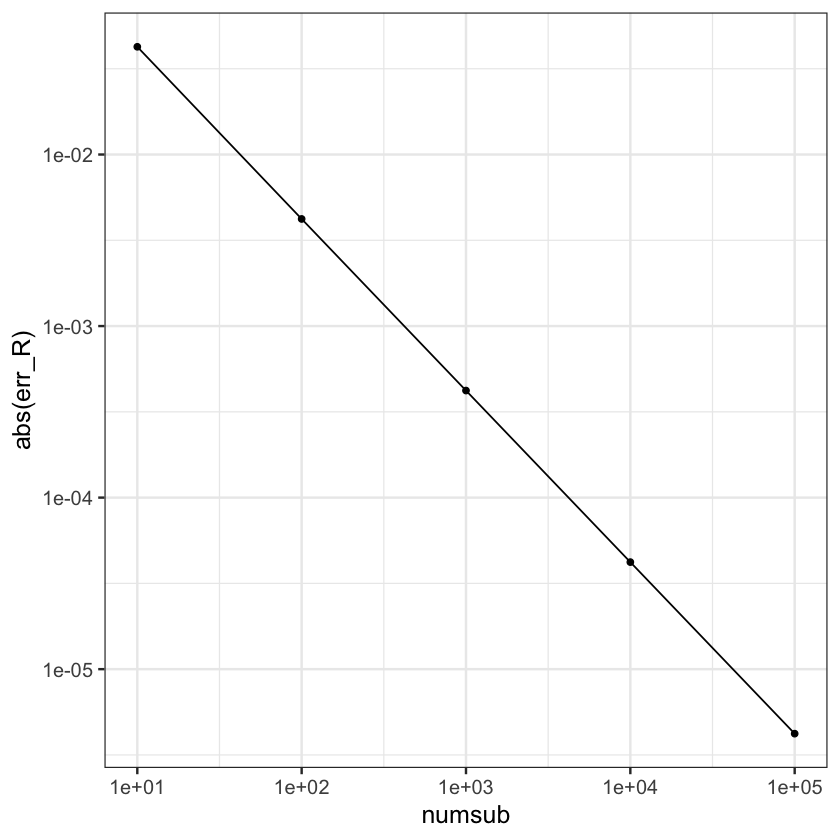

In [7]:
ggplot() + geom_point(aes(x=numsub, y=abs(err_R))) + geom_line(aes(x=numsub, y=abs(err_R))) + 
scale_x_log10() + scale_y_log10() + theme_bw(base_size = 15)

### Trapezoidal rule

* Approximate $f$ on $[x_i, x_{i+1}]$ by a linear function interpolating $(x_i, f(x_i))$ and $(x_{i+1}, f(x_{i+1}))$, i.e.,
$$
    p_i(x) = f(x_i) + \frac{f(x_{i+1}) - f(x_i)}{x_{i+1} - x_i}(x - x_i)
    .
$$
So
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx \approx \int_{x_i}^{x_{i+1}}p_i(x)dx = \frac{x_{i+1} - x_i}{2}[f(x_i) + f(x_{i+1})] = \frac{h}{2} [f(x_i) + f(x_{i+1})].
$$
and
$$
    I = \int_a^b f(x)dx \approx h\left(\frac{1}{2}f(a) + f(x_1) + \dotsb + f(x_{n-1}) + \frac{1}{2}f(b)\right) =: T(n)
    .
$$
* How accurate is the Trapezoidal rule? Assume again that $f$ is four-times continuously differentiable. Then,
$$
    f(x) = f(x_i) + (x - x_i)f'(x_i) + \frac{1}{2}(x - x_i)^2 f''(x_i) + \frac{1}{6}(x - x_i)^3f^{(3)}(x_i) + O(|x - x_i|^4)
$$
and
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx = h f(x_i) + \frac{h^2}{2}f'(x_i) + \frac{h^3}{6}f''(x_i) + \frac{h^4}{24}f^{(3)}(x_i) + O(h^5)
    .
$$
Also,
\begin{align*}
    \int_{x_i}^{x_{i+1}}p_i(x)dx &= \frac{h}{2} [f(x_i) + f(x_i+h)] \\
    &= \frac{h}{2}\left( f(x_i) + f(x_i) + h f'(x_i) + \frac{h^2}{2}f''(x_i) + \frac{h^3}{6}f^{(3)}(x_i) + O(h^4) \right) \\
    &= h f(x_i) + \frac{h^2}{2}f'(x_i) + \frac{h^3}{4}f''(x_i) + \frac{h^4}{12}f^{(3)}(x_i) + O(h^5)
\end{align*}
Therefore, 
\begin{align*}
    T(n) - I = \sum_{i=0}^{n-1}\left(I_i - \int_{x_i}^{x_{i+1}}p_i(x)dx\right) &= \frac{h^3}{12}\sum_{i=0}^{n-1}f''(x_i) + n O(h^4) \\
    &\le \frac{(b-a)^3}{12n^3} n \sup_{x\in [a, b]}|f''(x)| + n O\left(\frac{(b-a)^4}{n^4}\right) \\
    &= O(n^{-2})
    .
\end{align*}

In [8]:
trapezoidal <- function(f, a, b, n) {
    h <- (b - a) / n   
    
    xi <- seq.int(a, b, length.out = n + 1)
    xi <- xi[-1]
    xi <- xi[-length(xi)]

    intgrl <- h * (0.5 * f(a) + sum(f(xi)) + 0.5 * f(b))
    
    return(intgrl)
}

In [9]:
# f <- function(x) sqrt(1-x^2)   # integrand
trapezoidal(f, 0, 1, 100) 

[1] 0.4596939

In [10]:
truth

[1] 0.4596977

In [11]:
numsub <- c(10, 100, 1000, 10000, 100000)
err_T <- numeric(length(numsub))
for (i in seq_along(numsub)) {
    n <- numsub[i]
    T <- trapezoidal(f, 0, 1, n)
    err_T[i] <- T - truth
}

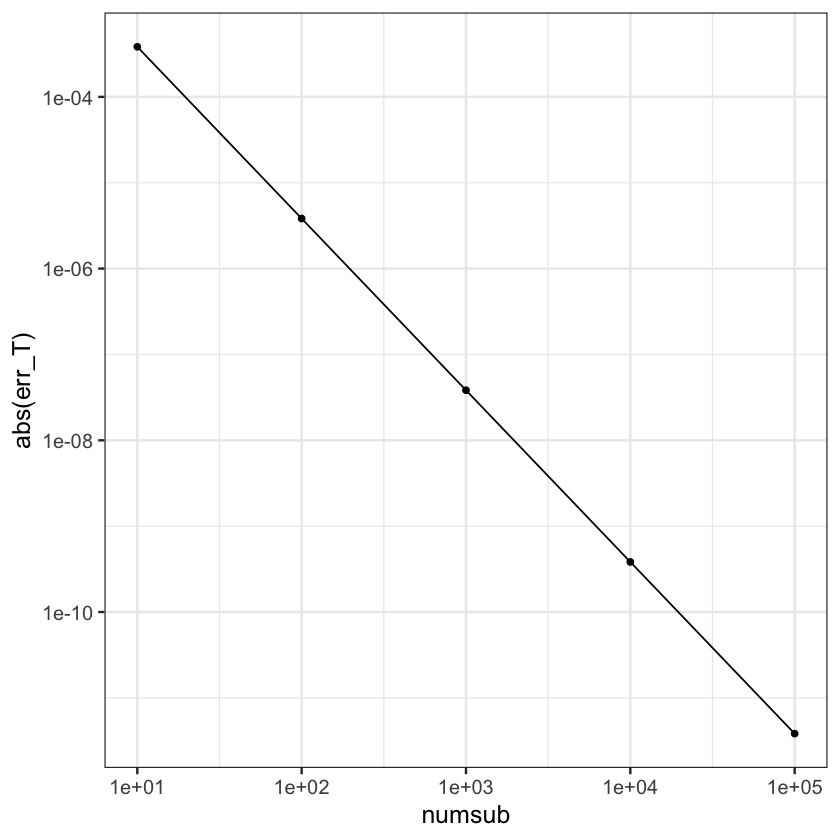

In [12]:
ggplot() + geom_point(aes(x=numsub, y=abs(err_T))) + geom_line(aes(x=numsub, y=abs(err_T))) + 
scale_x_log10() + scale_y_log10() + theme_bw(base_size = 15)

### Simpson's rule

* Approximate $f$ on $[x_i, x_{i+1}]$ by a quadratic function interpolating $(x_i, f(x_i))$, $\left(\frac{x_i + x_{i+1}}{2}, f\left(\frac{x_i + x_{i+1}}{2}\right)\right)$, and $(x_{i+1}, f(x_{i+1}))$, i.e., *equal-spacing* of interpolation points within the equally spaced intervals $[x_i, x_{i+1}]$. The interpolating quadratic is
\begin{align*}
    p_i(x) &= f(x_i)\frac{x - \frac{x_i + x_{i+1}}{2}}{x_i - \frac{x_i + x_{i+1}}{2}}\frac{x - x_{i+1}}{x_i - x_{i+1}} \\
    & + f\left(\frac{x_i + x_{i+1}}{2}\right)\frac{x - x_i}{\frac{x_i + x_{i+1}}{2} - x_i}\frac{x - x_{i+1}}{\frac{x_i + x_{i+1}}{2} - x_{i+1}} \\
    & + f(x_{i+1})\frac{x - x_i}{x_{i+1} - x_i}\frac{x - \frac{x_i + x_{i+1}}{2}}{x_{i+1} - \frac{x_i + x_{i+1}}{2}}
    .
\end{align*}
So
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx \approx \int_{x_i}^{x_{i+1}}p_i(x)dx = \frac{h}{6} \left[f(x_i) + 4f\left(\frac{x_i + x_{i+1}}{2}\right) + f(x_{i+1})\right].
$$
and
\begin{align*}
    I &= \int_a^b f(x)dx \approx h\left(\frac{1}{6}f(a) + \frac{2}{3}f(\frac{x_0 + x_1}{2}) + \frac{1}{3}f(x_1) + \frac{2}{3}f(\frac{x_1 + x_2}{2}) + \dotsb + \frac{1}{3}f(x_{n-1}) + \frac{2}{3}f(\frac{x_{n-1} + x_n}{2}) + \frac{1}{6}f(b)\right) \\
    &=: S(n)
    .
\end{align*}
* How accurate is the Simpson rule? Assume  that $f$ is five-times continuously differentiable. Then,
$$
    f(x) = f(x_i) + (x - x_i)f'(x_i) + \frac{1}{2}(x - x_i)^2 f''(x_i) + \frac{1}{6}(x - x_i)^3f^{(3)}(x_i) + \frac{1}{24}(x - x_i)^4f^{(4)}(x_i) + O(|x - x_i|^5)
$$
and
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx = h f(x_i) + \frac{h^2}{2}f'(x_i) + \frac{h^3}{6}f''(x_i) + \frac{h^4}{24}f^{(3)}(x_i) + \frac{h^5}{120}f^{(4)}(x_i) + O(h^6)
    .
$$
Also,
\begin{align*}
    \int_{x_i}^{x_{i+1}}p_i(x)dx &= \frac{h}{6} \left[f(x_i) + 4f\left(x_i + \frac{h}{2}\right) + f(x_i + h)\right] \\
    &= \frac{h}{6}\left( f(x_i) + 4f(x_i) + 2h f'(x_i) + \frac{h^2}{2}f''(x_i) + \frac{h^3}{12}f^{(3)}(x_i) + \frac{h^4}{96}f^{(4)}(x_i) + O(h^5) \right.\\
    & \left. \quad + f(x_i) + h f'(x_i) + \frac{h^2}{2}f''(x_i) + \frac{h^3}{6}f^{(3)}(x_i) + \frac{h^4}{24}f^{(4)}(x_i)
    + O(h^5) \right) \\
    &= h f(x_i) + \frac{h^2}{2}f'(x_i) + \frac{h^3}{6}f''(x_i) + \frac{h^4}{24}f^{(3)}(x_i) + \frac{5h^5}{576}f^{(4)}(x_i) + O(h^6)
\end{align*}
Therefore, 
\begin{align*}
    S(n) - I = \sum_{i=0}^{n-1}\left(I_i - \int_{x_i}^{x_{i+1}}p_i(x)dx\right) &= -\frac{h^5}{2880}\sum_{i=0}^{n-1}f^{(4)}(x_i) + n O(h^6) \\
    &\le \frac{(b-a)^5}{2880n^5} n \sup_{x\in [a, b]}|f^{(4)}(x)| + n O\left(\frac{(b-a)^6}{n^6}\right) \\
    &= O(n^{-4})
    .
\end{align*}

Note the jump of accuracy order from $O(n^{-2})$ (Trapezoidal) to $O(n^{-4})$ (Simpson)!

Also note that Simpson's method use **twice** more points than the Trapezoidal method. Hence for fair comparison, compare them with the same number of evaluation points.

In [13]:
simpson <- function(f, a, b, n) {
    h <- (b - a) / n   
    i <- seq_len(n - 1)
    xi <- a + i * h 
    xmid <- c(xi - h / 2, b - h / 2)
    intgrl <- h * (f(a) + 2 * sum(f(xi)) + 4 * sum(f(xmid)) + f(b)) / 6
   
    return(intgrl)
}

In [14]:
# f <- function(x) sqrt(1-x^2)   # integrand
simpson(f, 0, 1, 50)    # in fact about 100 pts

[1] 0.4596977

In [15]:
truth

[1] 0.4596977

Let's equate the total number of points.

In [16]:
simpson <- function(f, a, b, n) {
  h <- (b - a) / n
   
  xi <- seq.int(a, b, length.out = n + 1)
  xi <- xi[-1]
  xi <- xi[-length(xi)]
 
  intgrl <- (h / 3) * (f(a) + 2 * sum(f(xi[seq.int(2, length(xi), 2)])) + 
                       4 * sum(f(xi[seq.int(1, length(xi), 2)])) + f(b))
   
  return(intgrl)
   
}

In [17]:
simpson(f, 0, 1, 100)

[1] 0.4596977

In [18]:
truth

[1] 0.4596977

In [19]:
numsub <- c(10, 100, 1000, 10000, 100000)
err_S <- numeric(length(numsub))
for (i in seq_along(numsub)) {
    n <- numsub[i]
    S <- simpson(f, 0, 1, n)
    err_S[i] <- S - truth
}

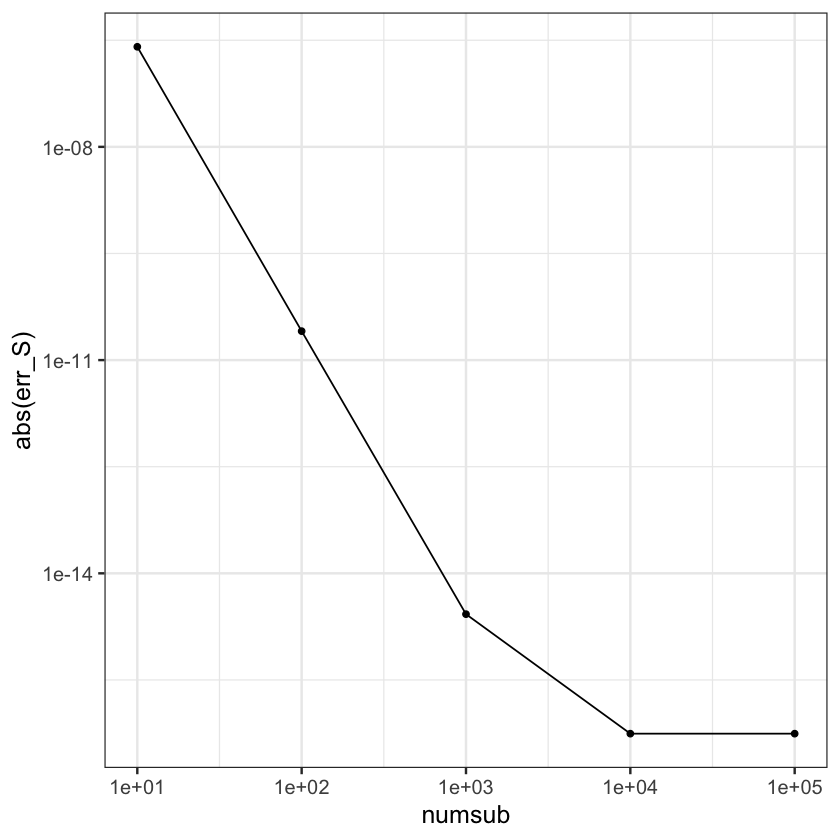

In [20]:
ggplot() + geom_point(aes(x=numsub, y=abs(err_S))) + geom_line(aes(x=numsub, y=abs(err_S))) + 
scale_x_log10() + scale_y_log10() + theme_bw(base_size = 15)

In [21]:
comp <- data.frame(method = factor(c(rep("riemann", length(numsub)), rep("trapezoidal", length(numsub)), 
                                rep("simpson", length(numsub)) )),
                   numsub = c(numsub = rep(numsub, 3)), 
                   error = c(err_R, err_T, err_S) )

In [22]:
comp

,method,numsub,error
,<fct>,<dbl>,<dbl>
numsub1,riemann,1e+01,-4.245669e-02
numsub2,riemann,1e+02,-4.211186e-03
numsub3,riemann,1e+03,-4.207738e-04
numsub4,riemann,1e+04,-4.207393e-05
numsub5,riemann,1e+05,-4.207359e-06
numsub6,trapezoidal,1e+01,-3.831453e-04
numsub7,trapezoidal,1e+02,-3.830821e-06
numsub8,trapezoidal,1e+03,-3.830814e-08
numsub9,trapezoidal,1e+04,-3.830813e-10


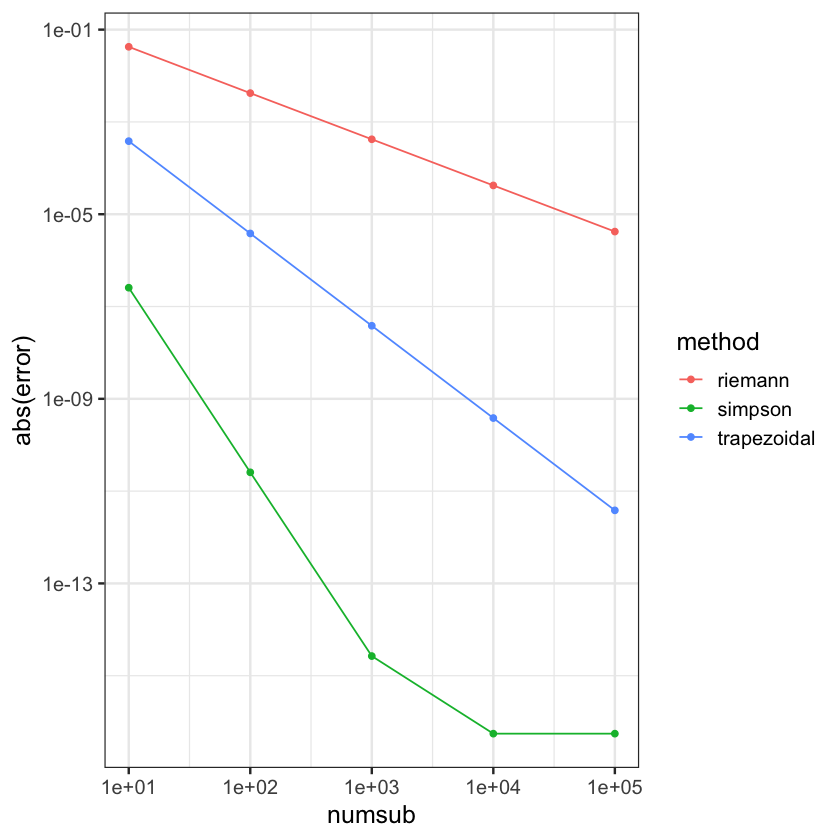

In [23]:
ggplot(data = comp, aes(numsub, abs(error))) + geom_point(aes(colour=method)) + geom_line(aes(colour=method)) + 
scale_x_log10() + scale_y_log10() + theme_bw(base_size = 15)

### General $m$

Use the Lagrange polynomial 
$$
L_{ij}^m(x) = \prod_{k\neq j}^{m+1} \frac{x - x_{ik}^*}{x_{ij}^* - x_{ik}^*}
$$
for equally spaced $x_{ij}^*$ in $[x_i, x_{i+1}]$ such that
$$
    p_i(x) = \sum_{j=0}^m f(x_{ij}^*)L_{ij}^m(x)
    .
$$

It is easy to check
$$
L_{ij}^m(x_{ik}^*) = \begin{cases} 1, & k = j , \\
                    0, & k \neq j.
                  \end{cases}
$$
Thus $p_i(x)$ is a polynomial of degree at most $m$ that interpolates $(x_{ij}^*, f(x_{ij}^*))$.

The Lagrange polynomial proves the *interpolation theorem*:

**Theorem 1**. Given $m+1$ distinct points $x_0, \dotsc, x_m \in \mathbb{R}$ and the corresponding values $y_0, \dotsc, y_m \in \mathbb{R}$, there exists a unique polynomial of degree at most $m$ that interpolates $\{(x_0, y_0), \dotsc, (x_m, y_m)\} \subset \mathbb{R}^2$.

*Proof* The existence of such a polynomial is shown above. To show uniqueness, let 
$$
    p(x) = \sum_{j=0}^m y_j L_j^m(x)
$$
be the interpolating polynomial constructed using the Lagrange polynomial, and $q(x)$ be another interpolating polynomial of degree at most $m$. Then we have
\begin{align*}
    p(x_0) &= q(x_0) \\
    &\vdots \\
    p(x_m) &= q(x_m),
\end{align*}
so that $f(x) = p(x) - q(x)$ has $m+1$ distinct roots. Since $f(x)$ is a polynomial of degree at most $m$, by the fundamental theorem of algebra, it can have at most $m$ roots. Therefore, $f(x) = 0$ for all $x$ or 
$$
    p(x) = q(x)
$$
for all $x$. 

**Corollary 1**. Let $f(x)$ is a polynomial of degree at most $m$. Suppose $x_0, \dotsc, x_m$ subdivide $[a, b]$ so that $x_0 = a$, $x_m = b$, and $x_j$'s are distinct.
Then
$$
    \int_a^b f(x)dx = \sum_{j=0}^m w_j f(x_j),
$$
where $w_j = \int_a^b L_j^m(x)dx$.

$f(x) = \sum_{j=0}^m f(x_j)L_j^m(x)$

## Gaussian quadrature

In Newton-Côtes quadrature, evaluation points $x_{ij}^*$ are **equally spaced** in $[x_i, x_{i+1}]$ and the integration $I_i$ is approximated as
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx \approx \sum_{j=0}^m w_{ij}f(x_{ij}^*)
$$
by choosing $w_{ij}$ optimally, in the sense that the approximation is *exact* if $f$ is up to $m$th degree polynomial (Corollary 1).

We may remove the *constraint* of equal spacing and optimally choose both $w_{ij}$ and $x_{ij}^*$.

**Theorem 2**. If $f$ is a polynomial of degree at most $2m+1$, then there exist $\{x_{i0}^*, \dotsc, x_{im}^*\} \subset [x_i, x_{i+1}]$ and $\{w_{i0}, \dotsc, w_{im}\} \subset \mathbb{R}$ such that
$$
    I_i = \int_{x_i}^{x_{i+1}}f(x)dx = \sum_{j=0}^m w_{ij}f(x_{ij}^*)
    .
$$
Furthermore, $w_{ij} > 0$ for all $j$.

Thus the quadrature rule using $m+1$ points can be exact up to $2m+1$ degree polynomial, a big improvement from Newton-Côtes.

### Review: Linear Algebra

Let $\mathcal{P}^m$ be the set of all polynomials of degree at most $m$. We all know that $\mathcal{P}^m$ is a vector space (over the real numbers) of dimension $m+1$, and $\{1, x, x^2, \dotsc, x^m\}$ forms a basis.

It is easy to check for any given distinct points $\{x_0, \dotsc, x_m\}$, $\{L_0^m(x), \dotsc, L_m^m(x)\}$ also forms a basis of $\mathcal{P}^m$.

Now consider an interval $(a, b) \subset \mathbb{R}$, and $\mathcal{P}^m(a,b)$ be the $\mathcal{P}^m$ restricted to $(a, b)$. If we define
$$
    \langle \mathbf{p}, \mathbf{q} \rangle = \int_a^b p(x)q(x)dx: \quad \mathbb{P}^m(a,b) \times \mathbb{P}^m(a,b) \to \mathbb{R}
$$
for $\mathbf{p}=p(x)$ and $\mathbf{q}=q(x)$ in $\mathbb{P}^m(a,b)$, then $\langle \mathbf{p}, \mathbf{q} \rangle$ is an inner product of $\mathbf{p}$ and $\mathbf{q}$, and $\mathbb{P}^m(a,b)$ is an inner product space:
1. $\langle \mathbf{p}, \mathbf{p} \rangle \ge 0$;
2. $\langle \mathbf{p}, \mathbf{p} \rangle = 0 \iff \mathbf{p} = 0$, i.e., $p(x)=0$ for all $x\in[a, b]$;
3. $\langle \alpha \mathbf{p}, \mathbf{q} \rangle = \alpha \langle \mathbf{p}, \mathbf{q} \rangle$, $\alpha \in \mathbb{R}$;
4. $\langle \mathbf{p}, \mathbf{q} \rangle = \langle \mathbf{q}, \mathbf{p} \rangle$;
5. $\langle \mathbf{p} + \mathbf{q}, \mathbf{r} \rangle = \langle \mathbf{p}, \mathbf{r} \rangle + \langle \mathbf{q}, \mathbf{r} \rangle$.

This inner product allows us to define a norm $\|\mathbf{p}\|$ over $\mathcal{P}^m(a,b)$:
$$
    \|\mathbf{p}\| = \langle \mathbf{p}, \mathbf{p} \rangle^{1/2} =
    \left(\int_a^b p^2(x)dx\right)^{1/2}.
$$

An orthonormal basis of $\mathcal{P}^m(a, b)$ can be constructed by using the Gram-Schmidt procedure: let $\mathbf{z}_j = z_j(x) = x^{j}$, $j=0, \dotsc, m$. Then set $\mathbf{q}_0 = \mathbf{z}_0 / \|\mathbf{z}_0\|$ and
\begin{align*}
    \tilde{\mathbf{q}}_j &= \mathbf{z}_j - \sum_{k=0}^{j-1}\langle \mathbf{z}_j, \mathbf{q}_k \rangle \mathbf{q}_k \\
    \mathbf{q}_j &= \tilde{\mathbf{q}}_j / \|\tilde{\mathbf{q}}_j\|
\end{align*}
for $j=0, \dotsc, m$. This amounts to
\begin{align*}
    \tilde{q}_j(x) &= x^j - \sum_{k=0}^{j-1}\left(\int_a^b t^j q_k(t) dt\right) q_k(x) \\
    q_j(x) &= \frac{\tilde{q}_j(x)}{\left(\int_a^b \tilde{q}_j^2(t)dt\right)^{1/2}}
\end{align*}

Orthogonal polynomial $q_j(x)$ are called the Legendre polynomial. Note that Legendre polynomials are nested:
$$
\text{span}\{\mathbf{q}_0, \dotsc, \mathbf{q}_m\}
= \mathcal{P}^{m}(a,b) \subset \mathcal{P}^{m+1}(a, b)
= \text{span}\{\mathbf{q}_0, \dotsc, \mathbf{q}_m, \mathbf{q}_{m+1} \}.
$$

### Proof of Theorem 2

*Proof of Theorem 2*. WLOG change the notation to $\{x_0=a, x_1, \dotsc, x_{m-1}, x_m = b\}$ and $\{w_0, \dotsc, w_m\}$. 

Since $\mathbf{f} = f(x) \in \mathcal{P}^{2m+1}(a, b)$, polynomial division yields
$$
    f(x) = g(x)q_{m+1}(x) + r(x),
$$
where $\mathbf{q}_{m+1} = q_{m+1}(x)$ is the $m+1$st Legendre polynomial in $\{\mathbf{q}_0, \dotsc, \mathbf{q}_{2m+1}\}$, which forms an orthonomal basis of $\mathcal{P}^{2m+1}(a, b)$; $\mathbf{g} = g(x)$ and $\mathbf{r} = r(x)$ are polynomials of degree at most $m$. By the construction of the Legendre polynomials, we see that 
$$
\langle \mathbf{g}, \mathbf{q}_{m+1} \rangle = \int_a^b g(x)q_{m+1}(x)dx = 0
.
$$
Thus $\int_a^b f(x)dx = \int_a^b r(x)dx$.

Now choose $x_0, \dotsc, x_m$ as the distinct real roots of the $m+1$st degree polynomial $q_{m+1}(x)$. 
(Such roots exist indeed; see Lemma 1 below.)
Then
$$
    f(x_j) = g(x_j)q_{m+1}(x_j) + r(x_j) = r(x_j), \quad j=0, \dotsc, m.
$$
From Corollary 1, 
$$
    \int_a^b r(x) dx = \sum_{j=0}^m w_j r(x_j), \quad w_j = \int_a^b L_j^m(x) dx,
$$
where $L_j^m(x)$ is the $j$th Lagrange polynomial given $\{x_0, \dotsc, x_m\}$ and $\{r(x_0), \dotsc, r(x_m)\}$.

Thus
$$
    \int_a^b f(x)dx = \int_a^b r(x) dx = \sum_{j=0}^m w_j r(x_j) = \sum_{j=0}^m w_j f(x_j),
$$
as desired.

It remains to show that $w_k > 0$ for any $k\in \{0, 1, \dotsc, m\}$. Set $f(x) = [L_k^m(x)]^2$, a $2m$-degree polynomial. By the definition of the Lagrange polynomial, 
$$
    f(x_j) = \begin{cases} 1 & j = k \\
                0 & j \neq k
             \end{cases}
$$
So,
$$
    0 < \int_a^b f(x) dx = \sum_{j=0}^m w_j f(x_j) = \sum_{j=0}^m w_j\delta_{jk} = w_k
    .
$$

**Lemma 1**. The roots of $k$th Legendre polynomial $q_k(x)$ are all real and distinct. 

*Proof*. Suppose the contrary is true. Then $q_k(x)$ changes its sign fewer than $k$ times. 
Let the roots of sign changes be $r_1 < \dotsb < r_l$ for $l < k$.
Then $q_k(x)\prod_{i=1}^l (x - r_i)$ will not suffer sign changes, only being zero at $r_1, \dotsc, r_l$. Thus
$$
    \int_a^b q_k(x)\prod_{i=1}^l (x - r_i) dx \neq 0,
$$
which is a contradiction since the degree of polynomial $\prod_{i=1}^l (x - r_i)$ is less than $k$ and is orthogonal to $q_k(x)$.

#### Degree $2m+1$ is maximal

Consider $f(x) = \prod_{j=0}^m (x-x_j)^2$, where $x_j$ are the roots of $q_{m+1}$. Obviously $f$ is a $(2m+2)$-degree polynomial. However,
$$
    0 < \int_a^b f(x) dx \neq \sum_{j=0}^m w_j f(x_j)
$$
since $f(x_j) = 0$ for all $j = 0, \dotsc, m$.

### Orthogonal polynomials

If we change the inner product of $\mathcal{P}^m(a, b)$ to 
$$
    \langle \mathbf{p}, \mathbf{q} \rangle = \int_a^b p(x)q(x)w(x) dx
$$
for a function $w(x)$ proportional to a density function on $(a, b)$, then the Gram-Schmidt procedure on $\{1, x, \dotsc, x^m\}$ generates a different sequence of orthogonal polynomials, where the orthogonality is with respect to $w$ (called $w$-orthogonal). The Legendre polynomial corresponds to the uniform distribution on $(a, b)$.

Typical choice of $w$ and associated $w$-orthogonal polynomials are tabulated:

| othogonal polynomial | weight function ($w(x)$)          | domain              | distribution|
|:---------------------|:---------------------------------:|:-------------------:|:------------|
| Legendre             |  1                                | $(-1, 1)$            | uniform     |
| Laguerre             | $x^{\alpha}e^{-x}$                | $(0, \infty)$       | gamma       |
| Hermite              | $e^{-x^2}$                        | $(-\infty, \infty)$ | normal      |
| Jacobi               | $(1-x)^{\alpha}(1+x)^{\beta}$ | $(-1, 1)$           | beta*       |

(*) After change of variable.

#### Legendre polynomial

The $m$th degree Legendre polynomial (on $(-1, 1)$) is a solution to Legendre's ordinary differential equation 
$$
    (1 - x^2)u'' - 2x u' + m(m + 1)m = 0
$$
given by
$$
    q_m(x) = \frac{(-1)^m}{2^m m!}\frac{d^m}{dx^m}[(1 - x^2)^m].
$$

#### Laguerre polynomial

The $m$th degree Laguerre polynomial is a solution to Laguerre's ordinary differential equation 
$$
    xu'' + (\alpha + 1 - x)u' + m u = 0
$$
given by
$$
    q_m(x) = \Gamma(m + \alpha)\sum_{k=0}^m\binom{m}{k}\frac{(-1)^k x^k}{\Gamma(k + \alpha)}.
$$


#### Hermite polynomial

The $m$th degree Hermite polynomial is a solution to Hermites's ordinary differential equation 
$$
    u'' - 2xu' + 2m u = 0
$$
given by
$$
    q_m(x) = (-1)^m e^{x^2}\frac{d^m}{dx^m}e^{-x^2}.
$$

#### Jacobi polynomial

The $m$th degree Jacobi polynomial is a solution to Jacobi's ordinary differential equation 
$$
    (1 - x^2)u'' + (\beta - \alpha + (\alpha + \beta + 2)x)u' + m(m + \alpha + \beta + 1) u = 0
$$
given by
$$
    q_m(x) = \frac{\Gamma(\alpha + m + 1)}{m!\Gamma(\alpha + \beta + m + 1)}\sum_{k=0}^m
    \frac{\Gamma(\alpha + \beta + n + m + 1)}{m!\Gamma(\alpha + m + 1)}
    \left(\frac{x - 1}{2}\right)^k
    .
$$




### Evaluation of orthogonal polynomials

What we need in Gaussian quadrature is the roots of the $m$th degree orthogonal polynomial (with respect to $w$). These roots are usually found by using Newton's method. The following properties of orthogonal polynomials are useful:

#### 3-term recursion

$$
    q_m(x) = (\alpha_m + x\beta_m)q_{m-1}(x) - \gamma_m q_{m-2}(x)
$$

for some sequence $\alpha_m$, $\beta_m$, and $\gamma_m$.


#### Interlacing property

If $\mu_1 < \dotsb < \mu_m$ are the roots of $q_m(x)$, then the roots of $q_{m+1}(x)$ lie in each of the intervals
$$
    (-\infty, \mu_1), ~ (\mu_1, \mu_2), \dotsc, (\mu_m, \infty).
$$


### Gauss-Hermite quadrature

If we want to integrate $f(x)$ from $-\infty$ to $\infty$, then Hermite polynomial is the choice:
$$
    \int_{-\infty}^{\infty} f(x)dx
    = \int_{-\infty}^{\infty} \left(\frac{f(x)}{e^{-x^2}}\right) e^{-x^2}dx
    \approx
    \sum_{j=0}^m w_j f(x_j)e^{x_j^2}
    ,
$$
where $\{w_j\}$ and $\{x_j\}$ are determined by the (scaled) Hermite polynomial.

* The approximation is good if $\hat{f}(x) = f(x)e^{x^2}$ is closed to a polynomial.

* If $\hat{f}$ is far from a polynomial, e.g., $f$ is concentrated on a point far from the origin, then $x_j$ will not be placed where most of the mass of $f$ is located, and GHQ may result in a poor approximation.
    - Example: $f(x) = \exp(-(x - \mu)^2/(2\sigma^2))$.
$$
        \int_{-\infty}^{\infty} f(x) dx 
        = \int_{-\infty}^{\infty} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} + x^2\right)\exp\left(-x^2\right)dx
$$
    - Then, 
$$
    \hat{f}(x) = \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} + x^2\right)
    \propto \exp\left(\left(1 - \frac{1}{2\sigma^2}\right)\left(x - \frac{\mu}{2\sigma^2 - 1}\right)^2 \right).
$$
    - If $\mu \gg 0$ or $\sigma^2 \gg 1$, then $\hat{f}$ will be difficult to approximate with a polynomial.
    
* Remedy: change of variable. Set $z = \frac{x - \mu}{\sqrt{2}\sigma}$. Then,
$$
    \int_{-\infty}^{\infty} f(x) dx = \sqrt{2}\sigma\int_{-\infty}^{\infty} e^{-z^2}dz
    = \sigma w_0, 
$$
a 1-point GHQ suffices!

In [24]:
# statmod::gauss.quad() calculates nodes and weights for Gaussian quadrature
statmod::gauss.quad(1, "hermite")   # this computes w_0

$nodes
[1] 0

$weights
[1] 1.772454

In [25]:
sqrt(pi)   # int_{-\infty}^{\infty}exp(-x^2)dx

[1] 1.772454

#### Example: Binomial-logit mixture

Suppose $x$ is a random sample from a Binomial distribution with $n$ trials and success probability $p=\frac{e^{\theta}}{1 + e^{\theta}}$.
Suppose the prior on $\theta$ is $N(0, \sigma^2)$. 

* Prior density: $f_{\Theta}(\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-x^2/(2\sigma^2)}$.
* Likelihood: $f_{X|\Theta}(x|\theta) = \binom{n}{x}p^x(1 - p)^{n-x}$, with
$p=\frac{e^{\theta}}{1 + e^{\theta}}$.
* Posterior density:
\begin{align*}
    f_{\Theta|X}(\theta|x) &= \frac{f_{X|\Theta}(x | \theta)f_{\Theta}(\theta)}{\int_{-\infty}^{\infty}f_{X|\Theta}(x | \theta')f_{\Theta}(\theta')d\theta'}
    = \frac{p(\theta)^x[1-p(\theta)]^{n-x}e^{-\theta^2/(2\sigma^2)}}{\int_{-\infty}^{\infty}p(\theta)^x[1-p(\theta)]^{n-x}e^{-\theta^2/(2\sigma^2)}d\theta}
    \\
    &= \frac{e^{\theta x}[1+e^{\theta}]^{-n}e^{-\theta^2/(2\sigma^2)}}{\int_{-\infty}^{\infty}e^{\theta x}[1+e^{\theta}]^{-n}e^{-\theta^2/(2\sigma^2)}d\theta}
\end{align*}

Thus if we define $g(\theta) = \frac{e^{\theta x}}{[1 + e^{\theta}]^n}$,
then the normalizing constant is
$$
\sigma\sqrt{2}\int_{-\infty}^{\infty} g(\sigma\sqrt{2}y)w(y)dy
$$ 
where $w(y) = e^{-y^2}$,
the weight function for the Hermite polynomials. However, this turns out to be a bad idea:

In [26]:
g <- function(theta, x, n) exp(theta * x - n * log(1 + exp(theta)))

x <- 18  # data
n <- 20  # sample size
sigma <- 10 # standard deviation of the prior

m <- 40   # degree of Hermite polynomial
ghq <- statmod::gauss.quad(m + 1, "hermite")
denom <- sigma * sqrt(2) * sum(g(sigma * sqrt(2) * ghq$nodes, x, n) * ghq$weights)
denom
# R built-in adaptive quadrature
integrate(function(y) sigma * sqrt(2) * g(sigma * sqrt(2) * y, x, n) * exp(-y^2) , -Inf, Inf) 

[1] 0.0002205171

0.002829073 with absolute error < 1.5e-09

The reason is that the integrand $g(\theta)$ has maximum at $p(\theta) = x/n = 0.9$ or $\theta = \log\frac{p}{1-p} = 2.197 \gg 0$.

A better apporach is the set $\bar{g}(\theta) = \frac{e^{\theta x}}{[1 + e^{\theta}]^n}e^{-\theta^2/(2\sigma^2)}=g(\theta)e^{-\theta^2/(2\sigma^2)}$ and find the maximizer $\theta^*$ of $\bar{g}$, and change the variable to $z = \theta - \theta^*$. Then, the normalizing constant is
$$
    \int_{-\infty}^{\infty}\bar{g}(\theta)d\theta 
    = \int_{-\infty}^{\infty} \bar{g}(z + \theta^*)dz
    = \int_{-\infty}^{\infty} \bar{g}(z + \theta^*)e^{z^2}e^{-z^2}dz
    = \int_{-\infty}^{\infty}\tilde{g}(z)w(z)dz,
$$
where 
$$
    \tilde{g}(z) = \bar{g}(z + \theta^*)e^{z^2}
    .
$$

In [27]:
theta_hat <- optimize(function(y) -g(y, x, n) * exp(-y^2 / sigma^2), c(-5, 5))$minimum  # univariate minimizer
theta_hat

[1] 2.173326

In [28]:
g2 <- function(z, x, n, sigma) g(z + theta_hat, x, n) * exp(-(z + theta_hat)^2 / 2 / sigma^2 + z^2) # g_tilde(z+theta_hat)
denom2 <- sum(g2(ghq$nodes, x, n, sigma) * ghq$weights)
denom2

[1] 0.002829073

## Laplace approximation

Laplace approximation concerns replacing the integral
$$
    \int_{-\infty}^{\infty} f(x)e^{-a g(x)} dx
$$
by optimization. WLOG assume that $g$ has its minimum at 0. If $g$ is three times continuously differentiable, then Taylor expansion around 0 yields
$$
    g(x) = g(0) + g'(0)x + \frac{1}{2}g''(0)x^2 + O(x^3) = g(0) + \frac{1}{2}g''(0)x^2 + o(x^2).
$$
Thus
$$
    \int_{-\infty}^{\infty} f(x)e^{-a g(x)} dx
    \approx
    f(0)e^{-a g(0)}\int_{-\infty}^{\infty}\exp\left(-\frac{a g''(0)x^2}{2}\right)dx
    = f(0)e^{-ag(0)}\sqrt{\frac{2\pi}{ag''(0)}}
$$
as $a \to \infty$, as in this case contributions to the integral is dominated by those around 0.
This amounts to reduce the integral to integration against $N(0, 1/[ag''(0)])$. A formal statement of the Laplace approximation is given below.

**Theorem 3**. If $g$ satisfies the following conditions
1. for every $\delta > 0$ there exists a $\rho > 0$ such that $g(x) - g(0) \ge \rho$ for all $x$ with $|x| \ge \delta$;
2. $g$ is twice continuously differentiable in a neighborhood of 0 and $g''(0) > 0$;
3. $f$ is continuous in a neighborhood of 0 and $f(0) > 0$;
4. the integral $\int_{-\infty}^{\infty}f(x)e^{-ag(x)}dx$ is absolutely convergent for $a \ge a_0$;

then, 
$$
    \int_{-\infty}^{\infty} f(x)e^{-a g(x)} dx
    \asymp
    f(0)e^{-ag(0)}\sqrt{\frac{2\pi}{ag''(0)}}
$$
as $a\to\infty$. That is, 
$$
    \lim_{a\to\infty} \left(\int_{-\infty}^{\infty} f(x)e^{-a g(x)} dx\right)/\left(f(0)e^{-ag(0)}\sqrt{\frac{2\pi}{ag''(0)}}\right) = 1.
$$

### Applications

#### Stirling's formula

The gamma function
$$
    \Gamma(t) = \int_0^{\infty} x^{t - 1}e^{-x} dx
$$
generalizes the factorial operation: $\Gamma(n+1) = n!$. If we define $z = x / t$, then
$$
    \Gamma(t+1) = t^{t+1}\int_0^{\infty}e^{-t g(z)}dz
$$
for $g(z) = z - \log z$. Since $g$ has its minimum at $z=1$, applying the Laplace approximation yields
$$
    \Gamma(t+1) \asymp \sqrt{2\pi}t^{t+1/2}e^{-t}
$$
as $t\to \infty$, which is the famous Stirling's formula for $t!$.

In [29]:
n <- 70
factorial(n)

[1] 1.197857e+100

In [30]:
sqrt(2*pi) * n^(n + 0.5) * exp(-n)

[1] 1.196432e+100

#### Posterior expectation

Recall Bayesian inference:

- Parameter $\theta$ has a prior density $f_{\Theta}(\theta)$ on $\mathbb{R}$
- Likelihood of data $x$ is $f_{X|\Theta}(x|\theta)$
- Posterior density
$$
    f_{\Theta|X}(\theta|x) = \frac{f_{X|\Theta}(x|\theta)f_{\Theta}(\theta)}{\int_{-\infty}^{\infty} f_{X|\Theta}(x|\theta')f_{\Theta}(\theta')d\theta'}
$$

We may want to evaluate posterior expectation $\mathbf{E}[h(\Theta) | X_1, \dotsc, X_n]$ given $n$ independent observations. The required expectation takes the form
$$
    \frac{\int e^{\tilde{h}(\theta)}e^{\ell_n(\theta) + \pi(\theta)}d\theta}{\int e^{l_n(\theta) + \pi(\theta)}d\theta}
$$
where $\tilde{h}(\theta) = \log h(\theta)$, $\ell_n(\theta) = \sum_{i=1}^n \log f_{X|\Theta}(x_i|\theta)$ is the the log likelihood of the data, and $\pi(\theta) = \log f_{\Theta}(\theta)$.

If $n$ is large, usually the log posterior $\ell_n(\theta) + \pi(\theta)$ is sharply peaked around $\hat{\theta}$, the posterior mode.

Using the Laplace approximation, the denominator is approximated by
$$
    \int e^{\ell_n(\theta) + \pi(\theta)}d\theta 
    \approx e^{\ell_n(\hat{\theta})+\pi(\hat{\theta})} 
    \sqrt{\frac{2\pi}{-[\ell_n''(\hat{\theta}) + \pi''(\hat{\theta})]}}
    .
$$

If $\tilde{h}(\theta) + \ell_n(\theta) + \pi(\theta)$ takes its maximum at $\tilde{\theta}$, then the numerator is approximated by
$$
    \int e^{\tilde{h}(\theta) + \ell_n(\theta) + \pi(\theta)}d\theta 
    \approx e^{\tilde{h}(\tilde{\theta}) + \ell_n(\tilde{\theta})+\pi(\tilde{\theta})} 
    \sqrt{\frac{2\pi}{-[\tilde{h}(\tilde{\theta}) + \ell_n''(\tilde{\theta}) + \pi''(\tilde{\theta})]}}
    .
$$

Thus the expectation is approximated by
$$
    \exp\left(\tilde{h}(\tilde{\theta}) + \ell_n(\tilde{\theta}) + \pi(\tilde{\theta}) 
    - \ell_n(\hat{\theta}) - \pi(\hat{\theta})\right)
    \sqrt{\frac{\ell_n''(\hat{\theta}) + \pi''(\hat{\theta})}{\tilde{h}''(\tilde{\theta}) + \ell_n''(\tilde{\theta}) + \pi''(\tilde{\theta})}}    
    .
$$

#### Example: binomial-logit mixture

Recall from the binomial-logit mixture example above, set 
$$
f(\theta) = e^{-\theta^2/(2\sigma^2)},
\quad
g(\theta) = -\theta x + n\log(1 + e^{\theta})
.
$$

Then the Laplace approximation of the normalization constant of the posterior density is
$$
f(\theta^*)e^{-g(\theta^*)}\sqrt{\frac{2\pi}{g''(\theta^*)}}
$$
where $\theta^* = \log\frac{x/n}{1 - x/n}$. It is easy to see that
$$
    g''(\theta^*) = n \frac{e^{\theta^*}}{(1 + e^{\theta^*})^2} = n p (1 - p),
    \quad
    p = x / n.
$$
For the numerical example of $x=18$ and $n=20$, we have the following:

In [31]:
x <- 18; n <- 20
p <- x / n
theta_star <-log(p / (1-p))
lap <- exp(-theta_star^2 / 2/ sigma^2) * exp(theta_star * x) / 
        (1 + exp(theta_star))^n * sqrt(2 * pi / n / p / (1 - p))
lap   # Laplace approximation
denom2  # Gauss-Hermite quadrature

[1] 0.002737382

[1] 0.002829073

#### Example: moments of beta distribution

Recall that the beta distribution has density 
$$
f_{\Theta}(\theta) 
= \frac{\Gamma(\alpha+\beta)\theta^{\alpha-1}(1-\theta)^{\beta-1}}{\Gamma(\alpha)\Gamma(\beta)} 
\propto \theta^{\alpha-1}(1-\theta)^{\beta-1}
$$ 
on $(0, 1)$. If the likelihood of the data $X$ is $\text{Binom}(n, \theta)$, then the posterior density of the success probability $\theta$ is also beta: $f_{\Theta|X}(\theta|x) \propto \theta^{\alpha + x -1}(1-\theta)^{\beta + n - x -1}$. Thus, finding the moment of a beta distribution amounts to computing the posterior moment of the success probability.

The exact value of $\mathbf{E}[\Theta^k]$ is
$$
    \mathbf{E}[\Theta^k] = \frac{\int_0^1 \theta^{k+\alpha-1}(1-\theta)^{\beta-1}d\theta}{\int_0^1\theta^{\alpha-1}(1-\theta)^{\beta-1}d\theta}
    = \frac{\Gamma(k + \alpha)\Gamma(\beta)}{\Gamma(k + \alpha + \beta)}
    \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}
    = \frac{\Gamma(k + \alpha)/\Gamma(\alpha)}{\Gamma(k + \alpha + \beta)/\Gamma(\alpha + \beta)}
    = \frac{(k+\alpha -1)\dotsb \alpha}{(k+\alpha+\beta-1)\dotsb(\alpha+\beta)}
$$

In order to apply the Laplace approximation, observe that $-\log(\theta^{\alpha-1}(1-\theta)^{\beta-1}) = -[(\alpha-1)\log\theta + (\beta-1)\log(1-\theta)] =: g(\theta)$, which has the unique minimum at $\hat{\theta} = \frac{\alpha-1}{\alpha+\beta-2}\in(0, 1)$. Therefore,
$$
    \int_0^1 \theta^{\alpha-1}(1-\theta)^{\beta-1} d\theta
    \approx e^{-g(\hat{\theta})}\sqrt{\frac{2\pi}{g''(\hat{\theta})}}
    = \left(\frac{\alpha-1}{\alpha+\beta-2}\right)^{\alpha-1}\left(\frac{\beta-1}{\alpha+\beta-2}\right)^{\beta-1}
    \sqrt{2\pi}\sqrt{\frac{(\alpha-1)(\beta-1)}{(\alpha+\beta-2)^3}}
$$
since $g(\hat{\theta}) = -\log\left[\left(\frac{\alpha-1}{\alpha+\beta-2}\right)^{\alpha-1}\left(\frac{\beta-1}{\alpha+\beta-2}\right)^{\beta-1}\right]$ and $g''(\hat{\theta}) = (\alpha-1)\left(\frac{\alpha+\beta-2}{\alpha-1}\right)^2 + (\beta-1)\left(\frac{\alpha+\beta-2}{\beta-1}\right)^2$.

Likewise,
$$
    \int_0^1 \theta^{k+\alpha-1}(1-\theta)^{\beta-1} d\theta
    \approx 
    \left(\frac{k+\alpha-1}{k+\alpha+\beta-2}\right)^{k+\alpha-1}\left(\frac{\beta-1}{k+\alpha+\beta-2}\right)^{\beta-1}
    \sqrt{2\pi}\sqrt{\frac{(k+\alpha-1)(\beta-1)}{(k+\alpha+\beta-2)^3}}
$$

Therefore,
$$
    \mathbf{E}[\Theta^k] \approx
    \left(\frac{(k+\alpha-2)(\alpha+\beta-2)^3}{(\alpha-1)(k+\alpha+\beta-2)^3}\right)^{1/2}
    \cdot
    \frac{\left(\frac{k+\alpha-1}{k+\alpha+\beta-2}\right)^{k+\alpha-1}\left(\frac{\beta-1}{k+\alpha+\beta-2}\right)^{\beta-1}}{\left(\frac{\alpha-1}{\alpha+\beta-2}\right)^{\alpha-1}\left(\frac{\beta-1}{\alpha+\beta-2}\right)^{\beta-1}}
$$

It can be shown that $\alpha, \beta \to \infty$ in such a way that $\frac{\alpha}{\alpha+\beta} \to p \in (0,1)$, then
the approximation of $\mathbf{E}[\Theta^k]$ tends to $p^k$. Also note that
$$
    \frac{(k+\alpha -1)\dotsb \alpha}{(k+\alpha+\beta-1)\dotsb(\alpha+\beta)} \to p^k
$$
in this setting. Thus the Laplace approximation of the beta moment is correct in the limit.

### Multidimensional integration

Laplace approximation naturally extends to multidimensional integration. On the contrary, quadrature methods needs  number of points that grows exponentially with dimension.

We will see later that Monte Carlo methods can also alleviate this difficulties.


### Proof of Theorem 3

Assume WLOG $g(0) = 0$ (multiply $e^{ag(0)}$ on both sides and set $g(x) := g(x) - g(0)$). 
From Condition 2,
$$
    g(x) = g(0) + g'(0)x + \frac{1}{2}g''(0)x^2 + o(x^2) = \frac{1}{2}g''(0)x^2 + o(x^2)
$$
as $x \to 0$.
Combining with condition 3, for a given small $\epsilon \in (0, \frac{1}{2}g''(0))$ there exists $\delta > 0$ such that
\begin{align*}
    (1-\epsilon) f(0) &\le f(x) \le (1+\epsilon) f(0)  \\
    -\epsilon x^2 &\le g(x) - \frac{1}{2}g''(0)x^2 \le \epsilon x^2
\end{align*}
for all $x$ with $|x| < \delta$.

Now examine the contributions to the integral from the region $|x| \ge \delta$. From condition 1, $g(x) \ge \rho$. Then for $a \ge a_0$,
\begin{align*}
    \left|\int_{\delta}^{\infty}f(x)e^{-ag(x)}dx\right|
    &\le \int_{\delta}^{\infty}|f(x)|e^{-(a - a_0)g(x)}e^{-a_0 g(x)}dx \\
    &\le e^{-(a - a_0)\rho}\int_{\delta}^{\infty}|f(x)|e^{-a_0 g(x)}dx \\
    &\le e^{-(a - a_0)\rho}\int_{-\infty}^{\infty}|f(x)|e^{-a_0 g(x)}dx 
    = O(e^{-\rho a})
    .
\end{align*}
The last equality is due to condition 4. By the same argument, we also have 
$$
\int_{-\infty}^{-\delta}f(x)e^{-ag(x)}dx = O(e^{-\rho a})
.
$$

The central portion of the integral can be bounded above:
\begin{align*}
    \int_{-\delta}^{\delta} f(x)e^{-ag(x)}dx 
    & \le (1+\epsilon)f(0)\int_{-\delta}^{\delta} e^{-\frac{a}{2}[g''(0)-2\epsilon]x^2} dx \\
    & \le (1+\epsilon)f(0)\int_{-\infty}^{\infty} e^{-\frac{a}{2}[g''(0) - 2\epsilon]x^2} dx\\
    &= (1+\epsilon)f(0)\sqrt{\frac{2\pi}{a[g''(0)- 2\epsilon]}}
    .
\end{align*}
Therefore,
$$
    \int_{-\infty}^{\infty} f(x)e^{-ag(x)}dx \le (1+\epsilon)f(0)\sqrt{\frac{2\pi}{a[g''(0)- 2\epsilon]}} + O(e^{-\rho a}),
$$
yielding
$$
    \limsup_{a\to\infty} \sqrt{a}\int_{-\infty}^{\infty} f(x)e^{-ag(x)}dx
    \le (1+\epsilon) f(0) \sqrt{\frac{2\pi}{g''(0)- 2\epsilon}}
    .
$$
Sending $\epsilon$ to zero, we have
$$
    \limsup_{a\to\infty} \sqrt{a}\int_{-\infty}^{\infty} f(x)e^{-ag(x)}dx
    \le f(0) \sqrt{\frac{2\pi}{g''(0)}}
    .
$$


We can also find a lower bound of the central portion of the integral:
\begin{align*}
    \int_{-\delta}^{\delta} f(x)e^{-ag(x)}dx 
    & \ge (1-\epsilon)f(0)\int_{-\delta}^{\delta} e^{-\frac{a}{2}[g''(0)+2\epsilon]x^2} dx 
    .
\end{align*}



For $|x| \ge \delta$, $(\frac{1}{2}g''(0) + \epsilon)x^2 \ge (\frac{1}{2}g''(0) + \epsilon)\delta^2 =: \lambda$. 
Furthermore, $\int_{-\infty}^{\infty} e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2} dx < \infty$ for any $a > 0$.
Hence by repeating the same argument leading to $\int_{\delta}^{\infty}f(x)e^{-ag(x)}dx = O(e^{-\rho a})$, we have
$$
    \int_{-\infty}^{-\delta}e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2}dx
    + \int_{\delta}^{\infty}e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2}dx
    = O(e^{-\lambda a}).
$$
Therefore,
\begin{align*}
    (1-\epsilon)f(0)\int_{-\delta}^{\delta} e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2} dx 
    &= (1-\epsilon)f(0)\int_{-\infty}^{\infty} e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2} dx \\
    & \quad - (1-\epsilon)f(0)\left[\int_{-\infty}^{-\delta}e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2} dx 
    + \int_{\delta}^{\infty}e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2} dx \right]
    \\
    &\ge (1-\epsilon)f(0)\int_{-\infty}^{\infty} e^{-\frac{a}{2}[g''(0) + 2\epsilon]x^2} dx - O(e^{-\lambda a}) \\
    &= (1-\epsilon)f(0)\sqrt{\frac{2\pi}{a[g''(0)+ 2\epsilon]}} + O(e^{-\lambda a})
    ,
\end{align*}
yielding
$$
    \liminf_{a\to\infty} \sqrt{a}\int_{-\infty}^{\infty} f(x)e^{-ag(x)}dx
    \ge (1-\epsilon) f(0) \sqrt{\frac{2\pi}{g''(0)+ 2\epsilon}}
    .
$$
Sending $\epsilon$ to zero, we have
$$
    \liminf_{a\to\infty} \sqrt{a}\int_{-\infty}^{\infty} f(x)e^{-ag(x)}dx
    \ge f(0) \sqrt{\frac{2\pi}{g''(0)}}
    .
$$


Thus
$$
    \lim_{a\to\infty} \sqrt{a}\int_{-\infty}^{\infty} f(x)e^{-ag(x)}dx
    = f(0) \sqrt{\frac{2\pi}{g''(0)}}
    .
$$
as desired.